# Notebook to demonstrate the issue I am having with dynesty

The data is in `data.dat` file.

I am trying to fit a spectrum, which contains four spectral lines. My model is, as I define it below, has four gaussians along with a linear baseline. I am trying to use dynesty to fit this model to the data, when I am unusual results in the computation of logz.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
import os
import dynesty
dynesty.__version__

'1.2.2'

Let's visualise the data:

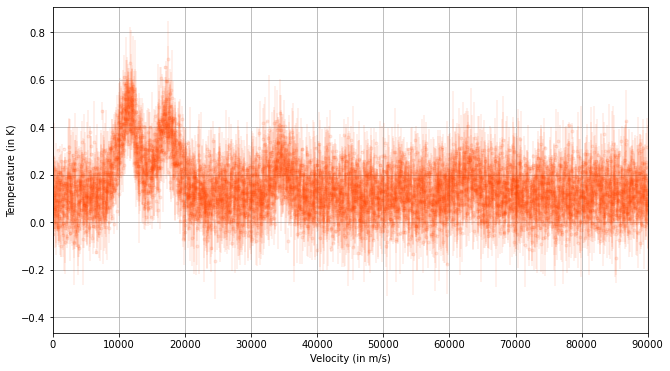

In [2]:
velo, temp, temp_err = np.loadtxt(os.getcwd() + '/data.dat', usecols=(0,1,2), unpack=True)
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(velo, temp, yerr=temp_err, fmt='.', c='orangered', alpha=0.1)
plt.xlabel('Velocity (in m/s)')
plt.ylabel('Temperature (in K)')
plt.xlim([0, 90000])
plt.grid()

And I want to fit four Gaussians (along with a linear baseline) to these data. The function is defined as below:

In [3]:
def line(x, m, c):
    return m*x + c

def gaus(x, amp, mu, sig):
    return amp*np.exp(-0.5 * ((x-mu)/sig)**2)

def model(x, m, c, am1, am2, am3, am4, mu1, mu2, mu3, mu4, si1, si2, si3, si4):
    ln1 = line(x, m, c)
    gau1 = gaus(x, am1, mu1, si1)
    gau2 = gaus(x, am2, mu2, si2)
    gau3 = gaus(x, am3, mu3, si3)
    gau4 = gaus(x, am4, mu4, si4)
    return ln1 + gau1 + gau2 + gau3 + gau4

And this is how I define the prior transform and the likelihood function.

In [4]:
def uniform(t, a, b):
    return (b-a)*t + a

def prior_transform(ux):
    x = np.array(ux)
    # Linear function:
    x[0], x[1] = uniform(ux[0], -0.01, 0.01), stats.loguniform.ppf(ux[1], a=1e-2, b=5e-1)
    # Amplitudes:
    x[2], x[3], x[4], x[5] = stats.loguniform.ppf(ux[2], a=1e-2, b=1.), stats.loguniform.ppf(ux[3], a=1e-2, b=1.),\
         stats.loguniform.ppf(ux[4], a=1e-2, b=1.), stats.loguniform.ppf(ux[5], a=1e-2, b=1.)
    # Central positions:
    x[6], x[7], x[8], x[9] = stats.norm.ppf(ux[6], loc=11000, scale=5e3), stats.norm.ppf(ux[7], loc=18000, scale=5e3),\
         stats.norm.ppf(ux[8], loc=35000, scale=5e3), stats.norm.ppf(ux[9], loc=62000, scale=5e3)
    # Widths:
    x[10], x[11], x[12], x[13] = stats.loguniform.ppf(ux[10], a=1e3, b=1e4), stats.loguniform.ppf(ux[11], a=1e3, b=1e4),\
         stats.loguniform.ppf(ux[12], a=1e3, b=1e4), stats.loguniform.ppf(ux[13], a=1e3, b=1e4)
    return x

def log_like(x):
    #global velo_avg, temp_avg, temp_err
    m, c, am1, am2, am3, am4, mu1, mu2, mu3, mu4, si1, si2, si3, si4 = x
    mods = model(velo, m, c, am1, am2, am3, am4, mu1, mu2, mu3, mu4, si1, si2, si3, si4)
    resid = temp-mods
    chi2 = np.sum(-resid**2/(2*temp_err*temp_err))
    errs = np.sum(-np.log(temp_err))
    return chi2+errs

And running `dynesty`...

In [5]:
dsampler = dynesty.DynamicNestedSampler(loglikelihood=log_like, prior_transform=prior_transform,\
    ndim=14, nlive=500, bound='multi', sample='rwalk')
dsampler.run_nested()
dres = dsampler.results

62392it [53:13, 19.54it/s, batch: 4 | bound: 5 | nc: 34 | ncall: 2061630 | eff(%):  3.026 | loglstar: -976412117.210 <   -inf < -976412116.450 | logz:   -inf +/-  3.143 | stop:  0.999]  


/Users/japa6985/opt/anaconda3/envs/dynesty12/lib/python3.9/site-packages/dynesty/utils.py:458: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")


(<Figure size 864x3024 with 28 Axes>,
 array([[<AxesSubplot:xlabel='$-\\ln X$', ylabel='$x_{1}$'>,
         <AxesSubplot:xlabel='$x_{1}$'>],
        [<AxesSubplot:xlabel='$-\\ln X$', ylabel='$x_{2}$'>,
         <AxesSubplot:xlabel='$x_{2}$'>],
        [<AxesSubplot:xlabel='$-\\ln X$', ylabel='$x_{3}$'>,
         <AxesSubplot:xlabel='$x_{3}$'>],
        [<AxesSubplot:xlabel='$-\\ln X$', ylabel='$x_{4}$'>,
         <AxesSubplot:xlabel='$x_{4}$'>],
        [<AxesSubplot:xlabel='$-\\ln X$', ylabel='$x_{5}$'>,
         <AxesSubplot:xlabel='$x_{5}$'>],
        [<AxesSubplot:xlabel='$-\\ln X$', ylabel='$x_{6}$'>,
         <AxesSubplot:xlabel='$x_{6}$'>],
        [<AxesSubplot:xlabel='$-\\ln X$', ylabel='$x_{7}$'>,
         <AxesSubplot:xlabel='$x_{7}$'>],
        [<AxesSubplot:xlabel='$-\\ln X$', ylabel='$x_{8}$'>,
         <AxesSubplot:xlabel='$x_{8}$'>],
        [<AxesSubplot:xlabel='$-\\ln X$', ylabel='$x_{9}$'>,
         <AxesSubplot:xlabel='$x_{9}$'>],
        [<AxesSubplot:xlabel='$-\\l

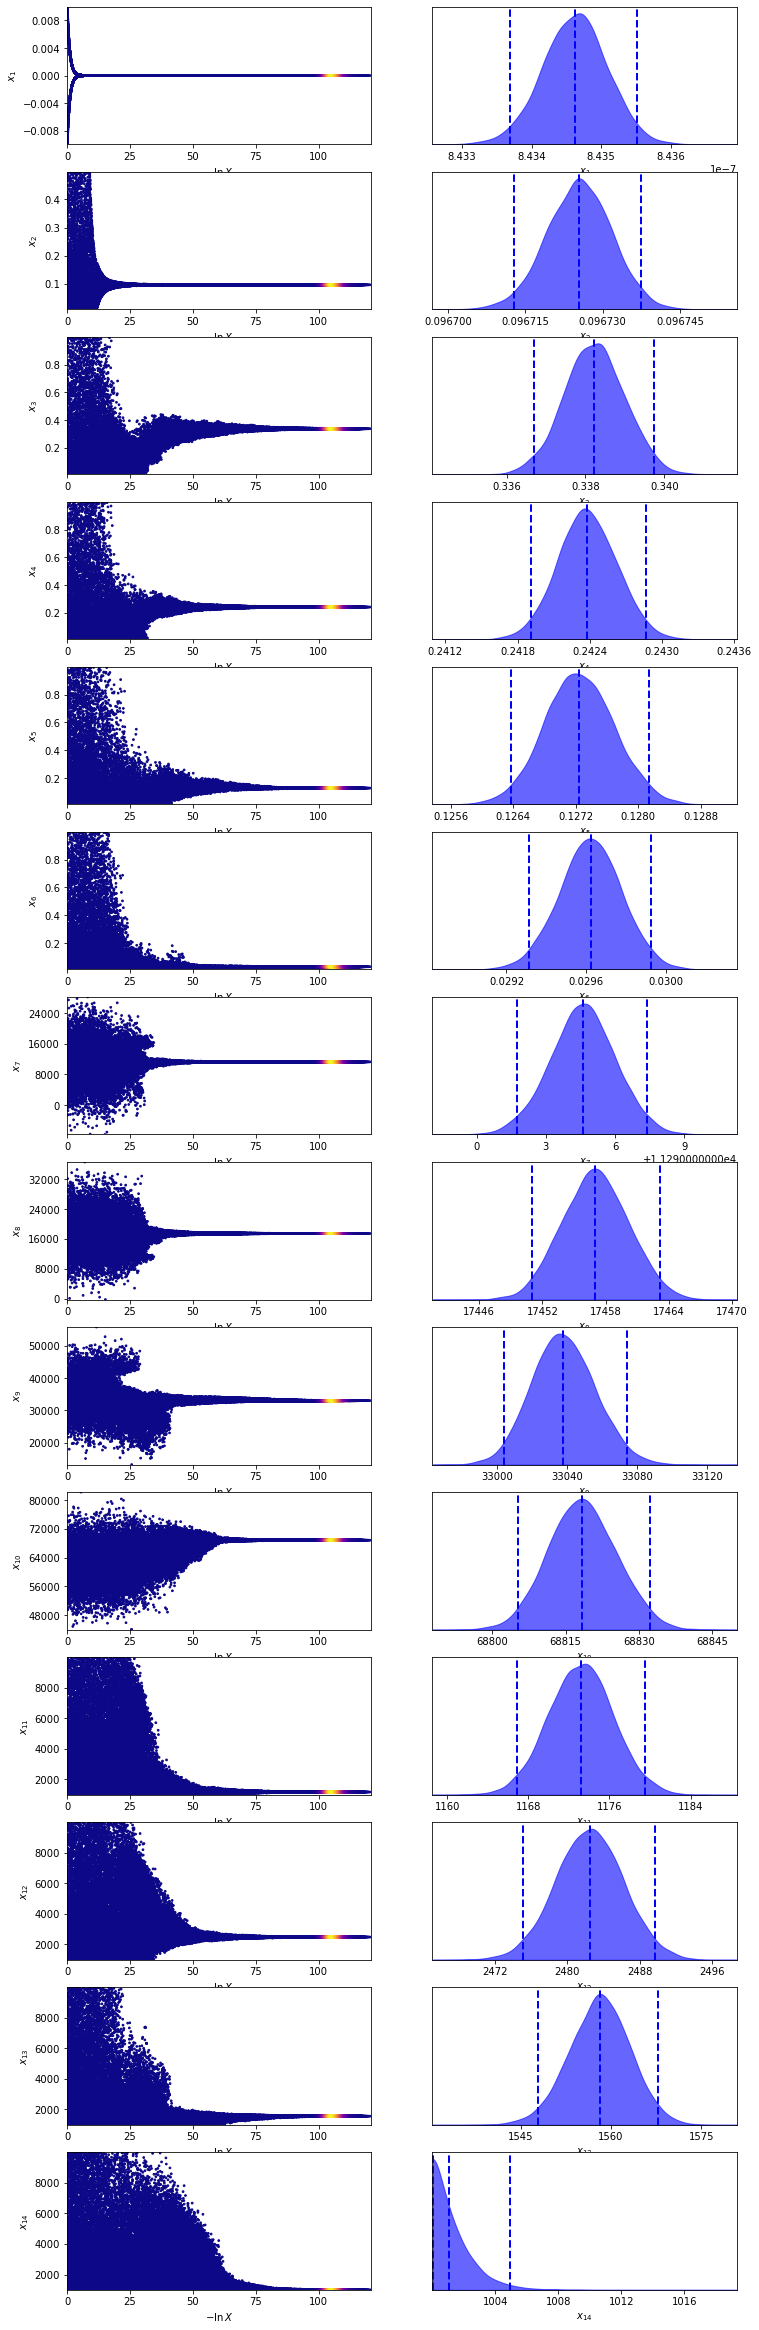

In [8]:
from dynesty import plotting as dyplot
dyplot.traceplot(dsampler.results)

(<Figure size 2210.4x2210.4 with 196 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='$x_{2}$'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='$x_{3}$'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='$x_{4}$'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplo

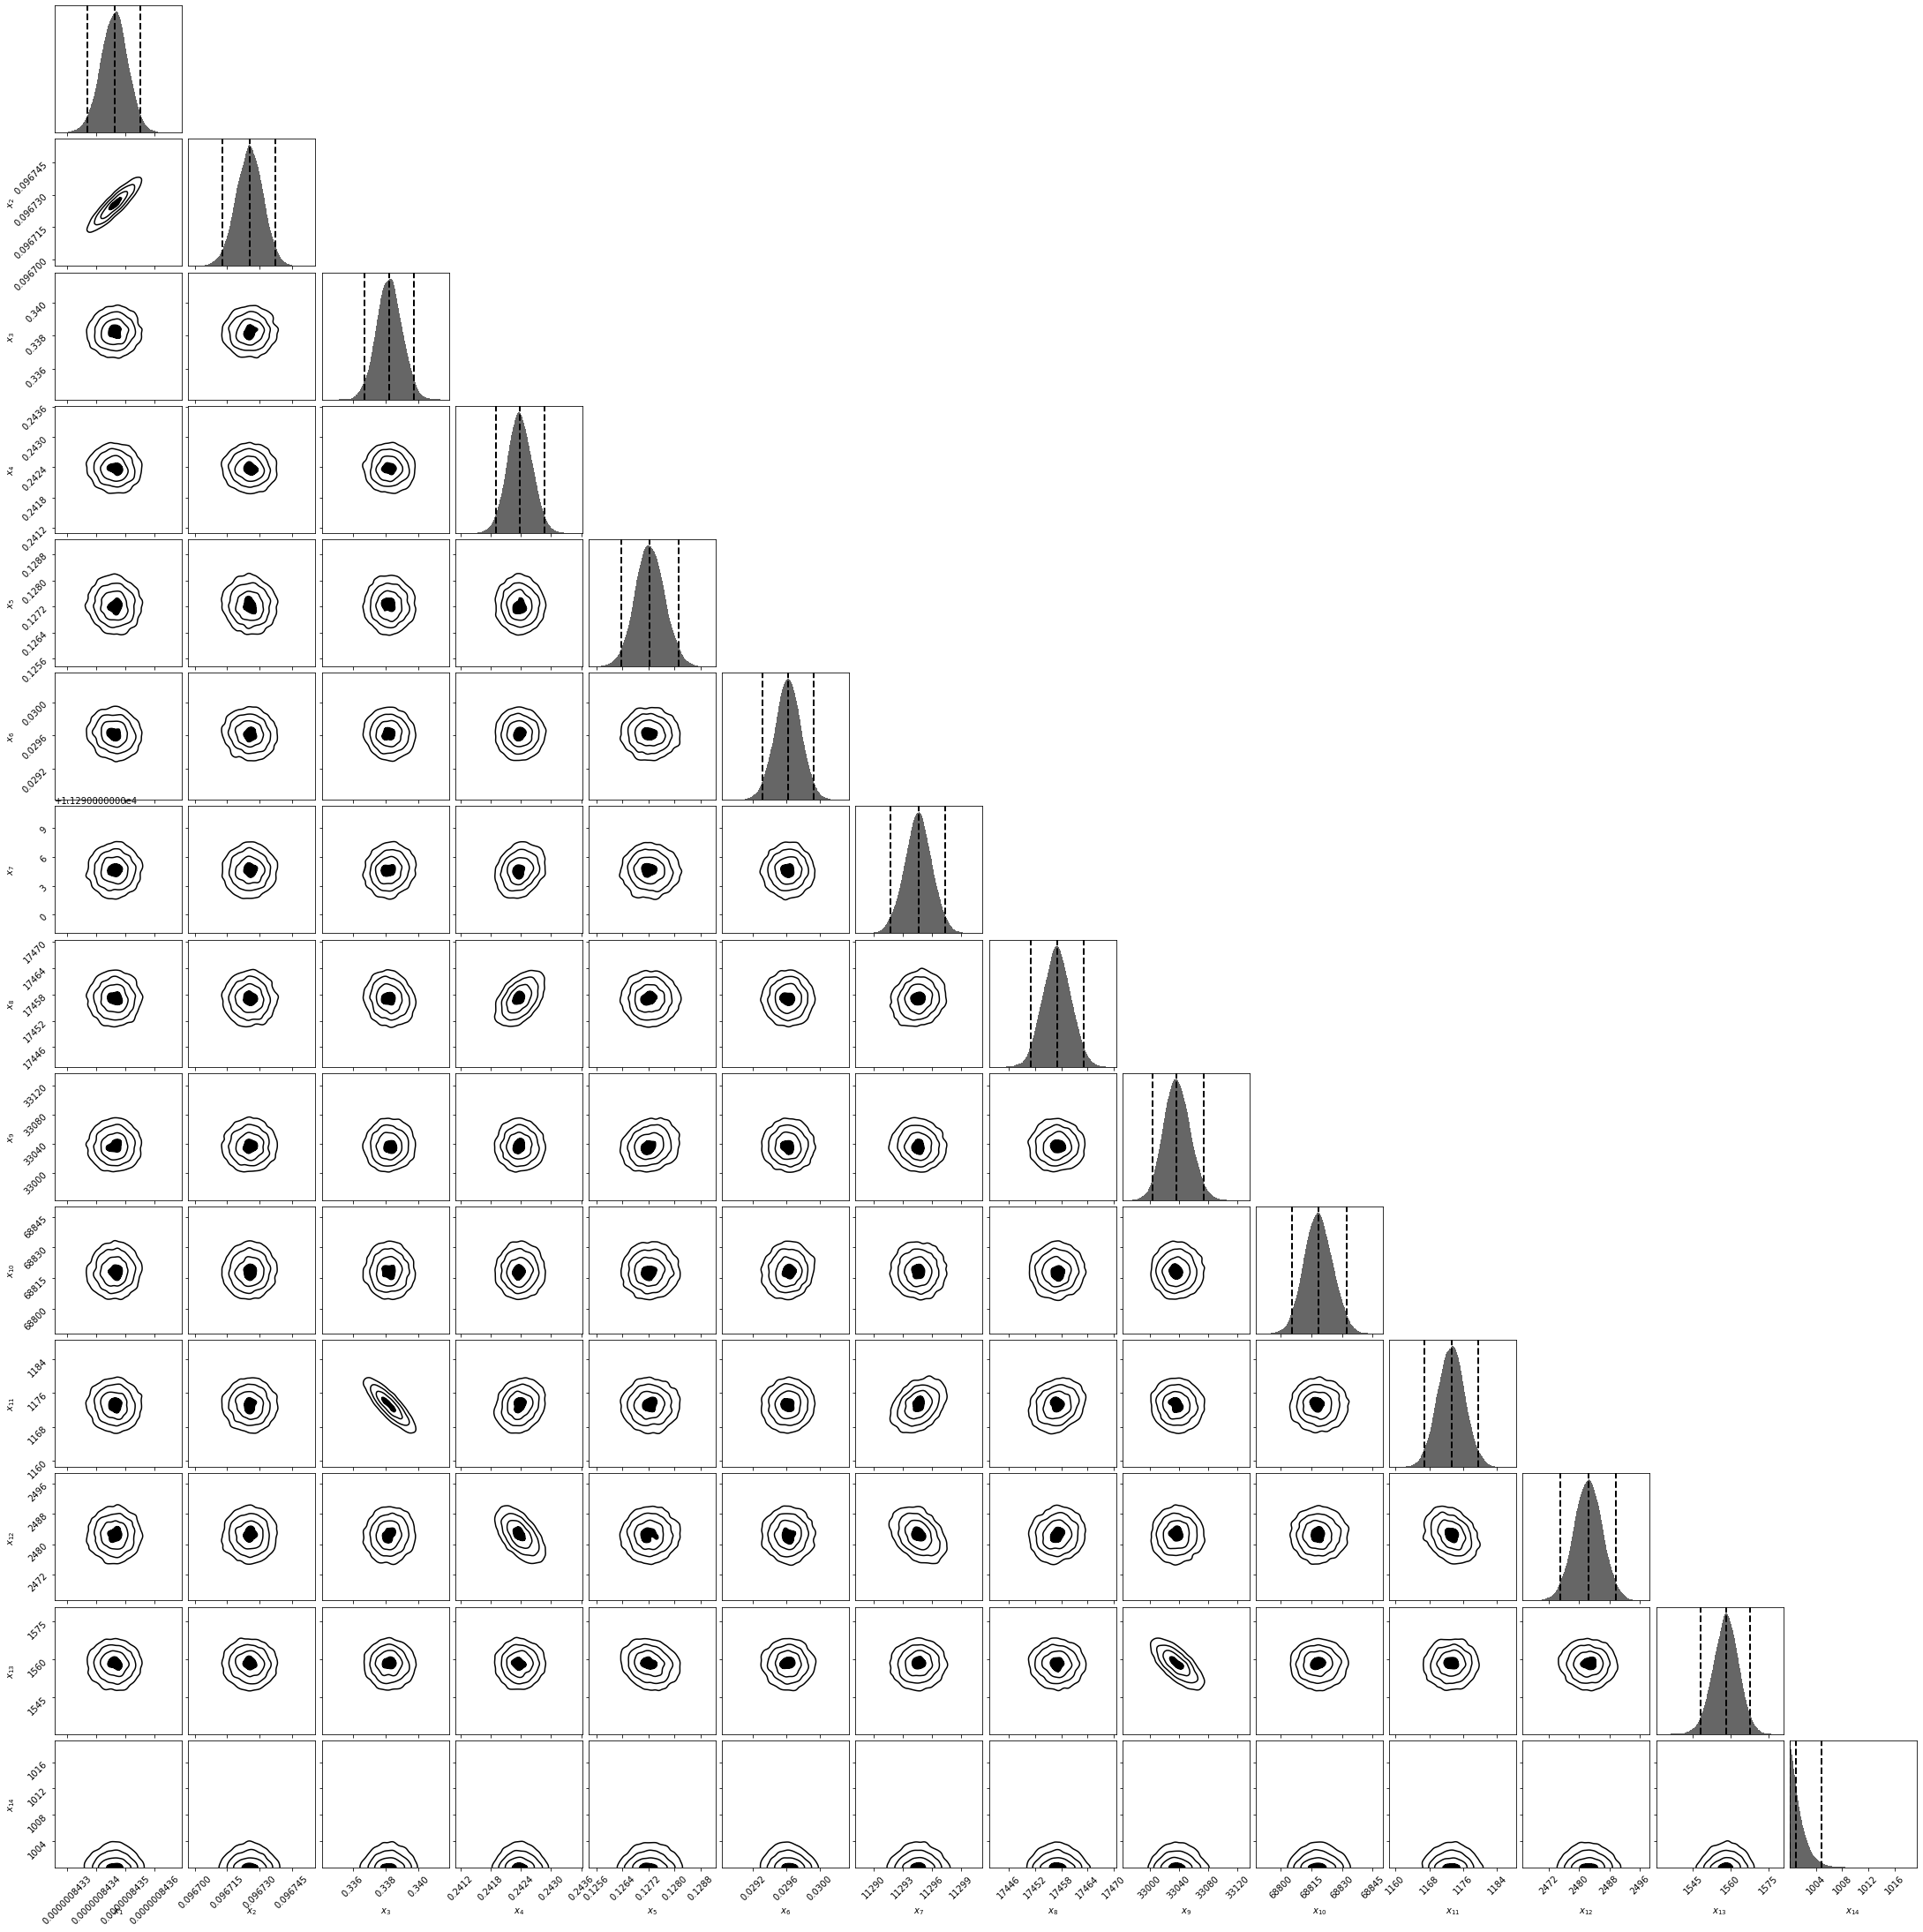

In [9]:
dyplot.cornerplot(dres)

In [11]:
print(dres.logz[-1])

-976412216.986027
